## Step 3: Sentiment analysis of customer reviews

### Loading and preparing the data

In [2]:
import json
import pandas as pd

In [3]:
reviews = []
with open("data/reviews.jsonl", "r", encoding="utf-8") as file:
    for line in file:
        review = json.loads(line)
        reviews.append({
            "rating": review["rating"],
            "title": review["title"],
            "text": review["text"],
        })

In [4]:
original_reviews_df = pd.DataFrame(reviews)
original_reviews_df.head()

,rating,title,text
0,4.0,No white background! It’s clear!,I bought this bc I thought it had the nice whi...
1,5.0,Awesome! Great price! Works well!,Perfect. How pissed am I that I recently paid ...
2,5.0,Worked but took an hour to install,Overall very happy with the end result. If you...
3,4.0,Decent,Lasted about 9 months then the lock button bro...
4,5.0,LOVE IT!,LOVE THIS CASE! Works better than my expensive...


In [5]:
# Sampling the data for faster processing
reviews_df = original_reviews_df.sample(200, random_state=42)

### Loading the pre-trained model

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [7]:
# Load the pre-trained model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model_tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [8]:
# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [9]:
# Set the model to evaluation mode: this means that some operations like dropout won't be applied
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [10]:
print(f"Model loaded on {device}")

Model loaded on cpu


### Data preprocessing

In [11]:
from torch.utils.data import Dataset, DataLoader
from typing import Dict
import torch
from transformers import AutoTokenizer
import pandas as pd

In [12]:
class ReviewDataset(Dataset):
    def __init__(
        self,
        reviews_df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        max_length: int = 512
    ) -> None:
        self.reviews = reviews_df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.reviews)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        review = self.reviews.iloc[idx]
        
        # Concatenate the title and text
        text = f"{review['title']} {review['text']}"
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "rating": torch.tensor(review["rating"], dtype=torch.float)
        }

In [13]:
def create_data_loader(
    df: pd.DataFrame,
    tokenizer: AutoTokenizer,
    batch_size: int = 8,
    max_length: int = 512
) -> DataLoader:
    """
    Creates a DataLoader for the reviews dataset
    """
    dataset = ReviewDataset(
        reviews_df=df,
        tokenizer=tokenizer,
        max_length=max_length
    )
    
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )

In [14]:
# Create a DataLoader for the reviews dataset
batch_size = 8
dataloader = create_data_loader(reviews_df, model_tokenizer, batch_size=batch_size)

In [15]:
first_batch = next(iter(dataloader))
print("Sample review:")
print(f"Input IDs shape: {first_batch['input_ids'].shape}")
print(f"Attention mask shape: {first_batch['attention_mask'].shape}")
print(f"Ratings shape: {first_batch['rating'].shape}")

Sample review:
Input IDs shape: torch.Size([8, 512])
Attention mask shape: torch.Size([8, 512])
Ratings shape: torch.Size([8])


### Sentiment prediction

In [16]:
from typing import Dict, List, Tuple
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader

In [17]:
def predict_sentiment(
    model: AutoModelForSequenceClassification,
    dataloader: DataLoader,
    device: torch.device
) -> Tuple[List[float], List[float]]:
    """
    Predicts the sentiment of the reviews using the provided model
    
    Returns:
    - predictions
    - actual_ratings
    """
    predictions = []
    actual_ratings = []
    
    # Disable gradient updates
    with torch.no_grad():
        for batch in dataloader:
            # Move the batch to the appropriate device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            ratings = batch["rating"].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Apply the softmax function to the logits
            probs = F.softmax(outputs.logits, dim=1)
            
            # Get the predicted ratings
            predicted_ratings = torch.argmax(probs, dim=1) + 1
            
            # Store the predictions and actual ratings
            predictions.extend(predicted_ratings.cpu().tolist())
            actual_ratings.extend(ratings.cpu().tolist())
    
    return predictions, actual_ratings

In [18]:
def calculate_metrics(
    predictions: List[float],
    actual_ratings: List[float]
) -> Dict[str, float]:
    """
    Calculates the performance metrics for the sentiment analysis model
    """
    predictions_tensor = torch.tensor(predictions)
    actual_ratings_tensor = torch.tensor(actual_ratings)
    
    # Pearson correlation
    correlation = torch.corrcoef(
        torch.stack([predictions_tensor.float(), actual_ratings_tensor.float()])
    )[0,1].item()
    
    # Accuracy
    accuracy = (predictions_tensor == actual_ratings_tensor).float().mean().item()
    
    return {
        "correlation": correlation,
        "accuracy": accuracy
    }

In [19]:
predictions, actual_ratings = predict_sentiment(model, dataloader, device)

In [20]:
metrics = calculate_metrics(predictions, actual_ratings)
print("\nPerformance metrics:")
print(f"Pearson correlation: {metrics['correlation']:.3f}")
print(f"Accuracy: {metrics['accuracy']:.3f}")


Performance metrics:
Pearson correlation: 0.874
Accuracy: 0.730


### Bonus: Visualizing the results

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import numpy as np

In [22]:
def create_comparison_plots(
        predictions: List[float],
        actual_ratings: List[float],
        figsize: Tuple[int, int] = (15, 5)
) -> None:
    """
    Creates comparison plots for the sentiment analysis results
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)

    # Actual vs. predicted ratings distribution
    df_plot = pd.DataFrame({
        "Predictions": predictions,
        "Actual ratings": actual_ratings
    })

    sns.kdeplot(data=df_plot, ax=ax1)
    ax1.set_title("Ratings distribution")
    ax1.set_xlabel("Rating (1-5)")
    ax1.set_ylabel("Density")

    # Boxplot of the ratings
    df_plot_melted = df_plot.melt(var_name="Type", value_name="Rating")
    sns.boxplot(data=df_plot_melted, x="Type", y="Rating", ax=ax2)
    ax2.set_title("Ratings boxplot")

    # Confusion matrix
    confusion = np.zeros((5, 5))
    for pred, actual in zip(predictions, actual_ratings):
        confusion[int(pred - 1)][int(actual - 1)] += 1

    sns.heatmap(
        confusion,
        annot=True,
        fmt="g",
        cmap="YlOrRd",
        ax=ax3,
        xticklabels=range(1, 6),
        yticklabels=range(1, 6)
    )
    ax3.set_title("Confusion matrix")
    ax3.set_xlabel("Actual ratings")
    ax3.set_ylabel("Predicted ratings")

    plt.tight_layout()
    plt.show()

In [23]:
def print_detailed_stats(
        predictions: List[float],
        actual_ratings: List[float]
) -> None:
    """
    Prints detailed statistics about the sentiment analysis results
    """
    pred_series = pd.Series(predictions)
    actual_series = pd.Series(actual_ratings)
    
    stats = {
        "mean predictions": pred_series.mean(),
        "mean actual ratings": actual_series.mean(),
        "std predictions": pred_series.std(),
        "std actual ratings": actual_series.std(),
        "median predictions": pred_series.median(),
        "median actual ratings": actual_series.median()
    }

    print("\nDetailed statistics")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")

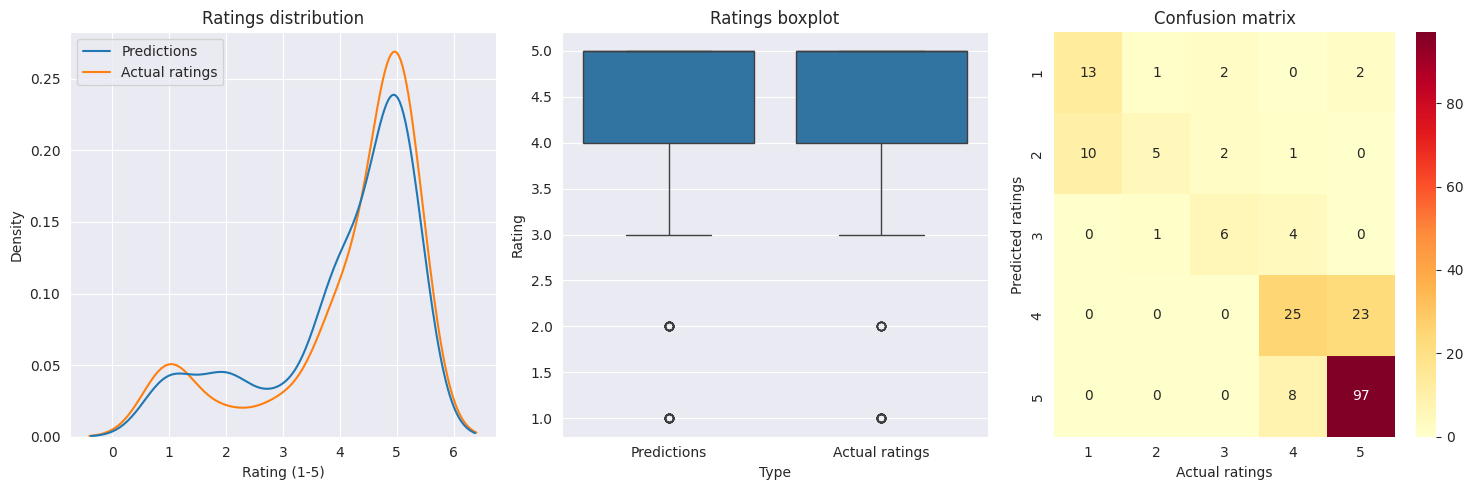

In [24]:
create_comparison_plots(predictions, actual_ratings)

Thanks to the above graphs, we can see that the model interprets the sentiments of the comments very well, since it finds the ratings given by the customers. The predicted ratings are very close to the actual ratings, even identical.

In [25]:
print_detailed_stats(predictions, actual_ratings)


Detailed statistics
mean predictions: 4.02
mean actual ratings: 4.14
std predictions: 1.33
std actual ratings: 1.35
median predictions: 5.00
median actual ratings: 5.00
